In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D
import os
import numpy as np
import cartopy.feature as cfeature

In [3]:
def get_map(ds, da):
    
    thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
    thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
    sg = xr.open_dataset(thedir+thefile)
    
    #ds = ds.isel(param=0).isel(minmax=0)
    out = np.zeros(sg.cclass.shape) + np.nan
    for c,(o,a) in enumerate(sg.rcent_coords):
        i = np.arange(400)[
            (abs(ds.grid1d_lat - a) < 0.1) &
            (abs(ds.grid1d_lon - o) < 0.1)]
        out[sg.cclass == c + 1] = i
    cclass = out.copy()
    cclass[np.isnan(out)] = 0

    sgmap = xr.Dataset()
    sgmap['cclass'] = xr.DataArray(cclass.astype(int), dims=['lat','lon'])
    sgmap['notnan'] = xr.DataArray(~np.isnan(out), dims=['lat','lon'])
    sgmap['lat'] = sg.lat
    sgmap['lon'] = sg.lon
    
    damap = da.sel(gridcell=sgmap.cclass).where(sgmap.notnan).compute()
    
    return damap

def annual_mean(da, cf):

    days_per_month = da['time.daysinmonth']
    ann_mean = cf*(days_per_month*da).groupby('time.year').sum()
    ann_mean.name = da.name

    return ann_mean

In [75]:
#ens = [241, 242]
#ens = [231, 232]
ens = [279, 280]
ens = [281, 282]
ens = [223, 224]

In [76]:
hist_dir = '/glade/work/afoster/FATES_calibration/history_files'
ensemble_dir = 'fates_sp_oaat'

dataset_min = xr.open_dataset(os.path.join(hist_dir, ensemble_dir, f'ctsm60SP_fates_sparsegrid_FATES_OAAT_{ens[0]}.nc'))
dataset_max = xr.open_dataset(os.path.join(hist_dir, ensemble_dir, f'ctsm60SP_fates_sparsegrid_FATES_OAAT_{ens[1]}.nc'))

# Extract data variables
lon = dataset_min['lon']
lat = dataset_min['lat']
dat_min = dataset_min['GPP']
dat_max = dataset_max['GPP']

In [78]:
da_map_min = get_map(dataset_min, mean_da_min)
da_map_max = get_map(dataset_max, mean_da_max)
da_diff = da_map_max - da_map_min

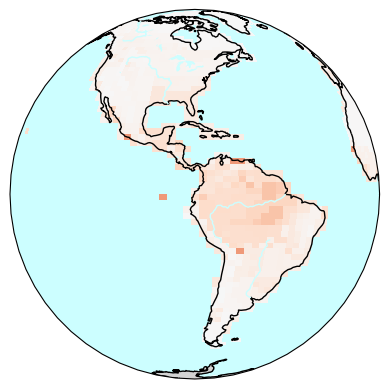

In [79]:
# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.Orthographic(central_longitude=-80, central_latitude=0))

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN, facecolor='#CCFEFF')
ax.add_feature(cfeature.LAKES, facecolor='#CCFEFF')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.RIVERS, edgecolor='#CCFEFF')
# # Plot your data on the 3D Earth
ax.pcolormesh(lon, lat, da_diff, transform=ccrs.PlateCarree(), vmin=-3, vmax=3, cmap='RdBu_r');
plt.savefig('/glade/u/home/afoster/FATES_Calibration/AGU_figures/gpp_diff_gs_int.png', transparent=True, dpi=300)